# Load modules

In [53]:
# Necessary imports
from skbio.embedding import ProteinEmbedding
from skbio.sequence import Protein
from tqdm import tqdm
import skbio

import torch

from deepblast.utils import load_model
from skbio.alignment import PairAlignPath
from deepblast.dataset.utils import get_sequence, pack_sequences, revstate_f
import matplotlib.pyplot as plt

def condense_cigar(cigar_str):
    """
    Convert full length to condensed CIGAR
    Example: MMMIIII = 3M4I
    """
    condensed_cigar = ''
    current_state = ''
    count = 0
    for i in range(len(cigar_str)):
        if cigar_str[i] == current_state:
            count += 1
        else:
            if count > 0:
                condensed_cigar += str(count) + current_state
            current_state = cigar_str[i]
            count = 1
    condensed_cigar += str(count) + current_state
    return condensed_cigar


def tm_to_cigar(tm_alignment_string, condensed=False):
    """
    Convert TMalign style alignment string to CIGAR string
    """

    cigar = ''

    for state in tm_alignment_string:
        if state == ':':
            cigar += 'M'
        elif state == '1':
            cigar += 'I'
        elif state == '2':
            cigar += 'D'

    return cigar

def align(x, y, model):
    pred_alignment = model.align(str(x), str(y))
    # TODO : need to convert TMalign style string to cigar
    cigar = tm_to_cigar(pred_alignment)
    cigar = condense_cigar(cigar)
    path = PairAlignPath.from_cigar(cigar)
    return pred_alignment

# Align sequences

In [24]:
model_name = "Rostlab/prot_t5_xl_uniref50"
tokenizer_name = "Rostlab/prot_t5_xl_uniref50"
from skbio import Protein

# Parse bagel.fa
sequence_list = skbio.io.read("bagel.fa", format='fasta', constructor=Protein)

In [25]:
x = next(sequence_list)
y = next(sequence_list)

In [54]:
# smith-waterman errored out because of the sting/path length missmatch

model = load_model("/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/tm-vec/models/deepblast-v3.ckpt", device="cpu",
                   alignment_mode="needleman-wunsch"
                   )

path = align(x, y, model)

/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/conda-envs/tmvec_slim/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [59]:
from deepblast.dataset.utils import states2matrix, tmstate_f


states = np.array(list(map(tmstate_f, path)))
path_matrix = states2matrix(states)

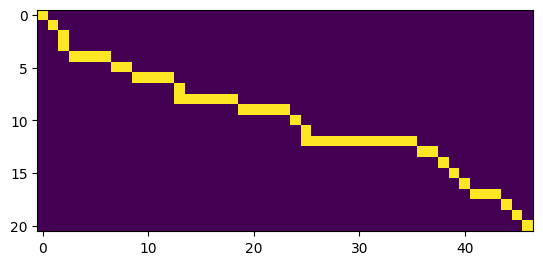

In [64]:
import matplotlib.pyplot as plt

plt.imshow(path_matrix);